#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Выводим первые 5 строк

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выведим общую информацию

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Данные с марта 2018 года по август 2018

In [4]:
df.sort_index(inplace=True)
df.index.is_monotonic

True

Временной ряд отсортирован в хронологическом порядке

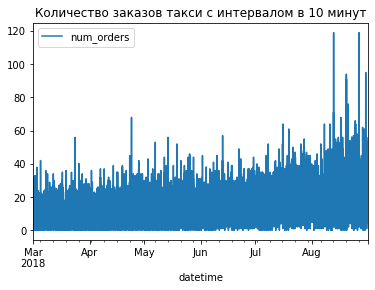

In [5]:
df.plot(title='Количество заказов такси с интервалом в 10 минут');

Сделаем ресемплирование изменим текущий интервал с 10 минут на один час

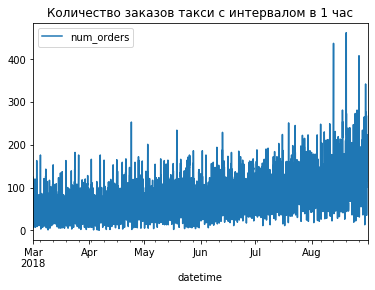

In [6]:
df_resample = df.resample('1H').sum()
df_resample.plot(title='Количество заказов такси с интервалом в 1 час');

Проверим на стационарность наш временной ряд

In [7]:
p = adfuller(df_resample['num_orders'],autolag='AIC')[1]
if p < 0.05:
    print('Ряд стационарен')
else:
    print('Ряд не стационарен')

Ряд стационарен


Разложим временной ряд на тренд и сезонность

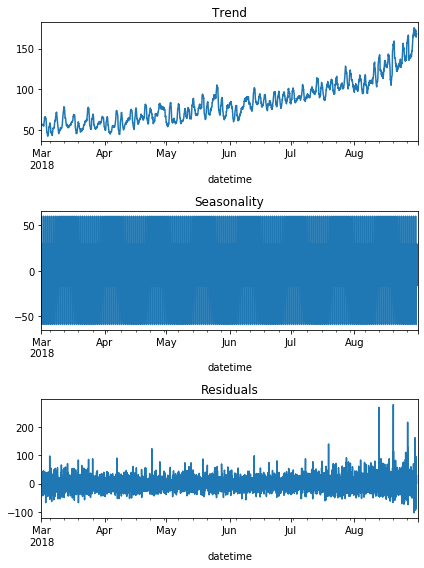

In [8]:
decomposed = seasonal_decompose(df_resample['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Видим увеличивающийся тренд в летний сезон пора отпусков люди чаще улетают в другие страны, а число заказов такси растет.

Напишем функцию make_features которая вернет нам год, месяц, день,день недели и является этот день выходным днем

In [9]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.dayofweek.isin([5,6])*1
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean().round()

Передадим в функцию значение max_lag,и скользящего среднего

In [10]:
make_features(df_resample,24, 7)

In [11]:
df_resample.tail(5)

,num_orders,year,month,day,dayofweek,is_weekend,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,2018,8,31,4,0,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,167.0
2018-08-31 20:00:00,154,2018,8,31,4,0,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.0
2018-08-31 21:00:00,159,2018,8,31,4,0,154.0,136.0,207.0,217.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,166.0
2018-08-31 22:00:00,223,2018,8,31,4,0,159.0,154.0,136.0,207.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,169.0
2018-08-31 23:00:00,205,2018,8,31,4,0,223.0,159.0,154.0,136.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,185.0


### Вывод
Ресемплировали временной ряд на 1 час, проверели на стационарность ряд оказался стационарным.Тренд и сезоность выяснили что люди летом чаще летеют и соответственно заказывают больше такси,создали признаки для прогнозирования num_orders  

## Обучение

Делим выборку на train и test 90/10

In [12]:
train,test = train_test_split(df_resample, shuffle=False, test_size=0.1)

In [13]:
print('Кол-во в обучающей выборке',train.shape[0])
print('Кол-во в тестовой выборке',test.shape[0])

Кол-во в обучающей выборке 3974
Кол-во в тестовой выборке 442


Удостоверимся правильно мы разбили выборку

In [14]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Удалим пропуски с train выборке

In [15]:
train = train.dropna()

Напишем функцию features_target которая разделит на целевой признак и признаки

In [16]:
def features_target(data):
    target = data['num_orders']
    features = data.drop('num_orders', axis=1)
    return features,target

In [17]:
features_train,target_train= features_target(train)
features_test,target_test= features_target(test)

In [108]:
lr = LinearRegression()
rf = RandomForestRegressor(random_state = 42,max_depth=20,min_samples_split=4,n_estimators=150)
lgbm =LGBMRegressor(random_state=42,max_depth=20,learning_rate=0.05,n_estimators=200)

In [99]:
def rmse_score(true_target,pred_target):
    rmse = mean_squared_error(true_target,pred_target) ** 0.5
    return rmse

In [94]:
def fit_result(model,f_train,t_train,f_test,t_test):
    model.fit(f_train,t_train)
    pred_train = model.predict(f_train)
    pred_test  = model.predict(f_test)
    train_score = rmse_score(t_train,pred_train)
    test_score = rmse_score(t_test,pred_test)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(211)
    t_train.plot(ax=plt.gca(),label='True target')
    pd.Series(pred_train,index=t_train.index).plot(ax=plt.gca(),label='Predicted target')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.text(t_train.index[10], 400, "rmse "+str(round(train_score,2)),fontsize=14)
    plt.title('Train')
    
    plt.subplot(212)
    t_test.plot(ax=plt.gca(),label='True target')
    pd.Series(pred_test,index=t_test.index).plot(ax=plt.gca(),label='Predicted target')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.text(t_test.index[1], 400, "rmse "+str(round(test_score,2)),fontsize=14)
    plt.title('Test')
    
    plt.tight_layout()
    return train_score, test_score

### LinearRegression

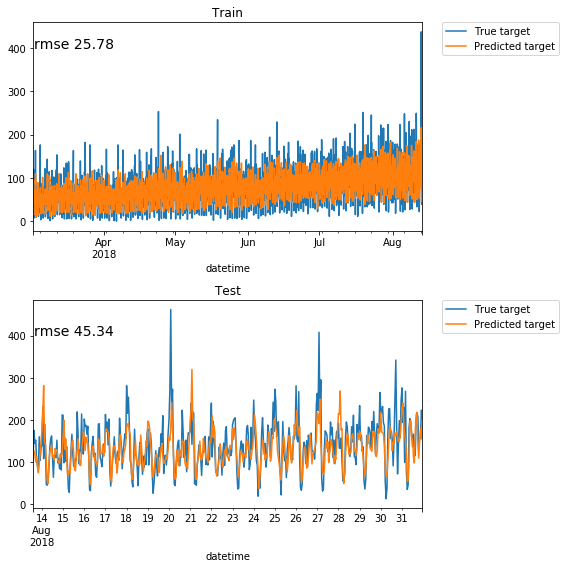

In [95]:
lr_train_score,lr_test_score = fit_result(lr,features_train,target_train,features_test,target_test)

### RandomForestRegressor

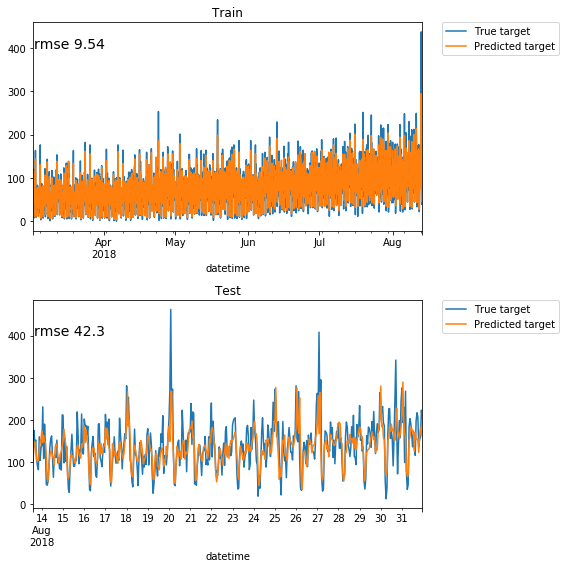

In [96]:
rf_train_score,rf_test_score = fit_result(rf,features_train,target_train,features_test,target_test)

### LGBMRegressor

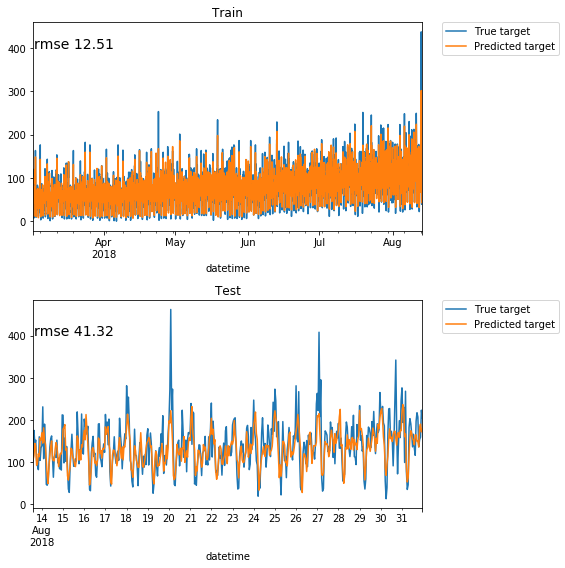

In [109]:
lgbm_train_score,lgbm_test_score = fit_result(lgbm,features_train,target_train,features_test,target_test)

## Тестирование

In [110]:
data = {'model':['LinearRegression','RandomForestRegressor','LGBMRegressor'],
                       'train_rmse':[lr_train_score,rf_train_score,lgbm_train_score],
                       'test_rmse': [lr_test_score,rf_test_score,lgbm_test_score]}
results = pd.DataFrame.from_dict(data)
results

,model,train_rmse,test_rmse
0,LinearRegression,25.781896,45.341667
1,RandomForestRegressor,9.538894,42.304257
2,LGBMRegressor,12.509526,41.324621


### Вывод 
Не плохо предсказывает временной ряд LinearRegression из всех 3 моделей у нее наименьшая разница между train и test score,RandomForestRegressor и LGBMRegressor явно переобучились и разрыв очень большой между скорами.